In [5]:
#get dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import keras
import preprocessing
import tensorflow as tf

In [6]:
#reproducability
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 42
np.random.seed(seed)
keras.utils.set_random_seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

In [8]:
#from keras import backend as K
#Force single thread
#session = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_config)
#K.set_session(session)

In [9]:
dataset = np.load('../data/dataset.npz',)
X, y = dataset['X'], dataset['y']
print(X.shape, y.shape)

(9834, 400) (9834,)


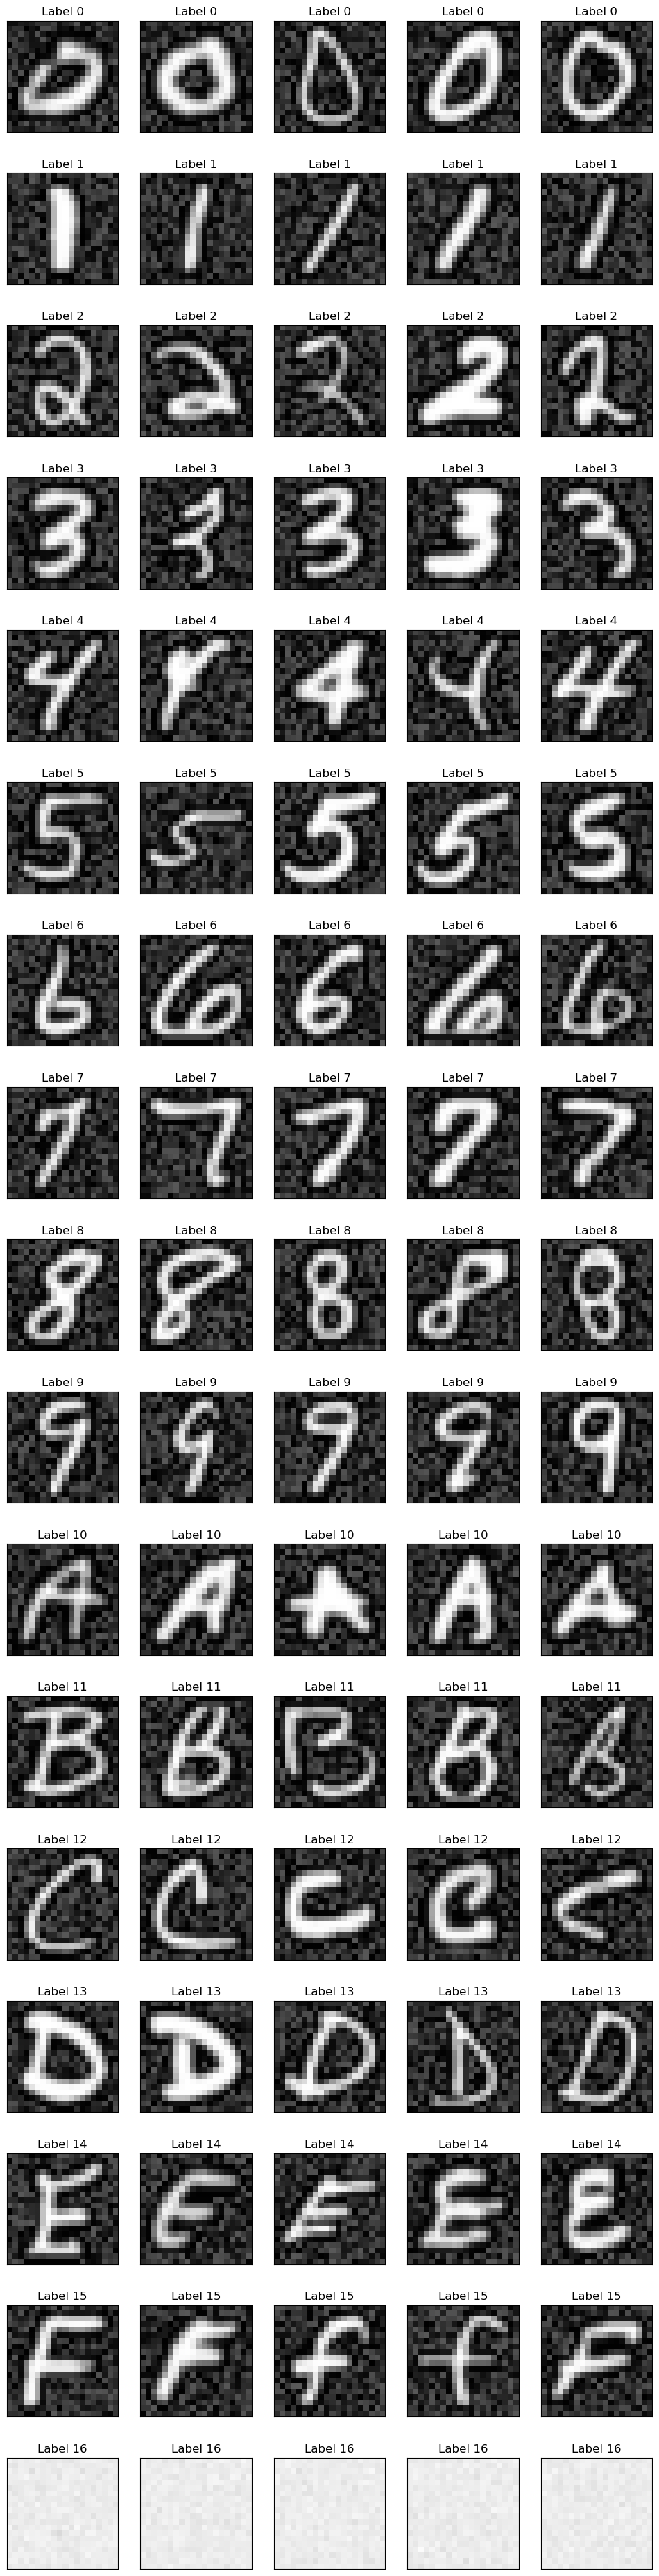

In [10]:
fig, axis = plt.subplots(17, 5, figsize=(12, 48))

for label in range(17):
    for i in range(5):
        axis[label, i].imshow(X[y == label][i+5].reshape(20, 20), vmin=0, vmax=255, cmap='gray')
        axis[label, i].set_xticks([])
        axis[label, i].set_yticks([])
        axis[label, i].set_title(f'Label {label}')

plt.show()

# Model testing

In [12]:
from sklearn.model_selection import train_test_split

#split data
X_train, X_val_test, y_train, y_val_test = train_test_split(X,y,train_size=.7,random_state=seed)
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test, train_size=.5, random_state=seed)

print(X_train.shape,y_train.shape,X_val.shape)

from preprocessing import generate_balanced_data
#print(X_train.shape,y_train.shape)
X_train_aug, y_train_aug = generate_balanced_data(X_train, y_train, seed=seed)
print(X_train_aug.shape)

(6883, 400) (6883,) (1475, 400)
(11747, 400)


# SVM

In [7]:
#quick and dirty >:)

from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
#want proba for each cat
svm = SVC(probability=True)
print(X_train.shape)
hyper_params = {
    'C' : [1e2, 1e1, 1e0],
    'gamma' : [0.0001,0.001],
    'kernel' : ['rbf','poly'],
    #'coef0' : [0, 1, 2],
}

rscv_1 = RandomizedSearchCV(estimator=svm,
                    random_state=seed,
                    param_distributions=hyper_params,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=2,
                    cv = 5
                    )


rscv_1.fit(X_train,y_train)

print(f"Best parameters: {rscv_1.best_params_}")
print(f"Best cross-validation score: {rscv_1.best_score_}")

UsageError: Line magic function `%%script` not found.


In [26]:
from sklearn.metrics import accuracy_score

best_svm = rscv_1.best_estimator_

y_pred_1 = best_svm.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_1)
print(f"accuracy_score (on val): {accuracy:.2f}")

NameError: name 'rscv_1' is not defined

# Using balanced dataset (w/ generated)

In [13]:
from preprocessing import generate_balanced_data
#print(X_train.shape,y_train.shape)
X_train_aug, y_train_aug = generate_balanced_data(X_train, y_train, seed=seed)
print(X_train_aug.shape)

(11747, 400)


In [ ]:

svm_aug = SVC(probability=True)

hyper_params = {
    'C' : [1e2, 1e1,1e0],
    'gamma' : [0.0001,0.001,0.1],
    'kernel' : ['rbf','poly'],
    #'coef0' : [0, 1, 2],
}

rscv = RandomizedSearchCV(estimator=svm_aug,
                    random_state=seed,
                    param_distributions=hyper_params,
                    #param_grid=hyper_params,
                    scoring='accuracy',
                    n_jobs=-1,
                    verbose=2,
                    cv = 5
                    )


rscv.fit(X_train_aug,y_train_aug)

print(f"Best parameters: {rscv.best_params_}")
print(f"Best cross-validation score: {rscv.best_score_}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .................C=100.0, gamma=0.0001, kernel=poly; total time= 1.1min
[CV] END .................C=100.0, gamma=0.0001, kernel=poly; total time= 1.1min
[CV] END .................C=100.0, gamma=0.0001, kernel=poly; total time= 1.1min
[CV] END .................C=100.0, gamma=0.0001, kernel=poly; total time= 1.0min
[CV] END .................C=100.0, gamma=0.0001, kernel=poly; total time= 1.1min
[CV] END ..................C=100.0, gamma=0.0001, kernel=rbf; total time= 5.1min
[CV] END ..................C=100.0, gamma=0.0001, kernel=rbf; total time= 5.1min
[CV] END ..................C=100.0, gamma=0.0001, kernel=rbf; total time= 5.2min
[CV] END ..................C=100.0, gamma=0.0001, kernel=rbf; total time= 5.2min
[CV] END ..................C=100.0, gamma=0.0001, kernel=rbf; total time= 5.3min
[CV] END ....................C=100.0, gamma=0.1, kernel=poly; total time= 1.1min
[CV] END ....................C=100.0, gamma=0.1,

In [ ]:
best_svm_aug= rscv.best_estimator_
y_pred_aug = best_svm_aug.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_aug)
print(f"accuracy_score (on val w/ aug): {accuracy:.2f}")


accuracy_score (on val w/ aug): 0.89


In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from matplotlib import cm

conf_matrix = confusion_matrix(y_val, y_pred_aug)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=cm.Blues)
plt.show()
print("error, true = 13 (D) pred = 0\n")

NameError: name 'y_pred_aug' is not defined

# Some troch/keras testing

In [14]:
#import torch
#import torch.nn as nn
#import torch.nn.functional as F
#import keras
from keras.layers import Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
#import tensorflow
keras.utils.set_random_seed(seed)
#reshape to single images 20x20
X_train = X_train.reshape(X_train.shape[0], 20, 20, 1)
X_train_aug = X_train_aug.reshape(X_train_aug.shape[0], 20, 20, 1)
X_val = X_val.reshape(X_val.shape[0], 20, 20, 1)
X_test = X_test.reshape(X_test.shape[0], 20, 20, 1)

#might need reshape somehow ;--)
#print(y_train[:16])

#y_train = y_train.reshape

#found online, rly cool func! (to_categorical)
y_train = keras.utils.to_categorical(y_train, num_classes=17)
y_val_4_score = keras.utils.to_categorical(y_val, num_classes=17)
y_train_aug = keras.utils.to_categorical(y_train_aug, num_classes=17)

#-----
#lenet struct
cnn = keras.Sequential()
#add convulutional layer, filter should be pow2 (4 converging)
cnn.add(Convolution2D(padding="same",filters=16, kernel_size=(3,3), activation='relu', input_shape = (20,20,1)))
print(cnn.output_shape)
#add pooling layer (Downsampling)
cnn.add(MaxPooling2D(pool_size=(2,2)))
print(cnn.output_shape)
cnn.add(Convolution2D(filters=32,kernel_size=(3,3), activation='relu'))
print(cnn.output_shape)
cnn.add(MaxPooling2D(pool_size=(2,2)))
print(cnn.output_shape)
#flatten outpu
cnn.add(Flatten())
#fully connected layer / back to std NN (kinda)
cnn.add(Dense(128, activation='relu'))
#dropout ensures no slacking!!
cnn.add(Dropout(rate=.2))
#output layer (softmax for probas)
cnn.add(Dense(17,activation='softmax'))
print(cnn.output_shape)
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn.fit(X_train,y_train, epochs=10)
score = cnn.evaluate(X_val,y_val_4_score,verbose=1)
cnn.summary()


(None, 20, 20, 16)
(None, 10, 10, 16)
(None, 8, 8, 32)
(None, 4, 4, 32)
(None, 17)
Epoch 1/10


2024-10-05 23:22:19.000645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [6883,17]
	 [[{{node Placeholder/_11}}]]
2024-10-05 23:22:19.000835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [6883,17]
	 [[{{node Placeholder/_11}}]]
2024-10-05 23:22:19.031247: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


216/216 [==============================] - 1s 3ms/step - loss: 3.4835 - accuracy: 0.4948
Epoch 2/10
216/216 [==============================] - 1s 3ms/step - loss: 0.7390 - accuracy: 0.7840
Epoch 3/10
216/216 [==============================] - 1s 3ms/step - loss: 0.4535 - accuracy: 0.8626
Epoch 4/10
216/216 [==============================] - 1s 3ms/step - loss: 0.3233 - accuracy: 0.8955
Epoch 5/10
216/216 [==============================] - 1s 3ms/step - loss: 0.2672 - accuracy: 0.9125
Epoch 6/10
216/216 [==============================] - 1s 3ms/step - loss: 0.2292 - accuracy: 0.9246
Epoch 7/10
216/216 [==============================] - 1s 2ms/step - loss: 0.1868 - accuracy: 0.9394
Epoch 8/10
216/216 [==============================] - 1s 3ms/step - loss: 0.1401 - accuracy: 0.9502
Epoch 9/10
216/216 [==============================] - 1s 3ms/step - loss: 0.1164 - accuracy: 0.9609
Epoch 10/10
47/47 [==============================] - 0s 913us/step - loss: 0.2413 - accuracy: 0.9315
Model: "se

2024-10-05 23:22:25.109104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1475,17]
	 [[{{node Placeholder/_11}}]]
2024-10-05 23:22:25.109267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1475,17]
	 [[{{node Placeholder/_11}}]]


In [15]:
print(f"Score on val data: loss = {score[0]}, metric = {score[1]} ")

Score on val data: loss = 0.2412642389535904, metric = 0.9315254092216492 


Score on val data: loss = 0.27259156107902527, metric = 0.9315254092216492 


# with augmented data

In [38]:
#yo hello
cnn.fit(X_train_aug,y_train_aug, epochs=10)
score_aug = cnn.evaluate(X_val,y_val_4_score,verbose=1)

Epoch 1/10
368/368 [==============================] - 1s 2ms/step - loss: 0.4323 - accuracy: 0.8695
Epoch 2/10
368/368 [==============================] - 1s 3ms/step - loss: 0.3035 - accuracy: 0.9041
Epoch 3/10
368/368 [==============================] - 1s 3ms/step - loss: 0.2458 - accuracy: 0.9207
Epoch 4/10
368/368 [==============================] - 1s 3ms/step - loss: 0.1995 - accuracy: 0.9359
Epoch 5/10
368/368 [==============================] - 1s 3ms/step - loss: 0.1815 - accuracy: 0.9414
Epoch 6/10
368/368 [==============================] - 1s 3ms/step - loss: 0.1687 - accuracy: 0.9452
Epoch 7/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1384 - accuracy: 0.9556
Epoch 8/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1204 - accuracy: 0.9586
Epoch 9/10
368/368 [==============================] - 1s 2ms/step - loss: 0.1154 - accuracy: 0.9610
Epoch 10/10
47/47 [==============================] - 0s 925us/step - loss: 0.2614 - accuracy: 0.9444

In [39]:
print(f"Score on val data(w/aug): loss = {score_aug[0]}, metric = {score_aug[1]} ")

Score on val data(w/aug): loss = 0.2613691985607147, metric = 0.9444068074226379 


In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from matplotlib import cm

y_pred_cnn_prob_1 = cnn.predict(X_val)
y_pred_cnn_1 = predictions = np.argmax(cnn.predict(X_val),axis=1)
print(y_val)
print("--")
print(y_pred_cnn_1)
conf_matrix = confusion_matrix(y_val, y_pred_cnn_1)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=cm.Blues)
plt.show()
print("error, true = 13 (D) pred = 0\n")

AttributeError: 'KerasClassifier' object has no attribute 'model'

# hyper param tuning

In [1]:
from keras.optimizers import Adam
import keras_tuner
# Helper function for LeNet style CNN model
def LeNetCNN(kernel_size, activation, n_filters, pool_size, drop_out_rate,loss,learning_rate):
    optimizer = Adam(learning_rate=learning_rate)
    
    model = keras.Sequential()
    #input layer
    model.add(Convolution2D(filters=n_filters, kernel_size=kernel_size, activation=activation, input_shape = (20,20,1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Convolution2D(filters=n_filters, kernel_size=kernel_size, activation=activation, input_shape = (20,20,1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    #flatten outpu
    model.add(Flatten())
    model.add(Dropout(rate=drop_out_rate))
    model.add(Dense(128, activation=activation))
    #output layer (softmax for probas)
    model.add(Dense(17,activation='softmax'))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

ModuleNotFoundError: No module named 'keras_tuner'

In [22]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

h_params = {
    "kernel_size" : [(3,3), (5,5)],
    "activation" : ['relu','sigmoid'],
    "n_filters" : [32, 64, 128],
    "pool_size" : [(2,2), (4,4)],
    "drop_out_rate" : [0.2,0.5],
    "loss" : ['categorical_crossentropy'],
    "learning_rate" : [0.0001,0.001,0.01]
}

cnn = KerasClassifier(build_fn=LeNetCNN, epochs=10,)


gscv = GridSearchCV(estimator=cnn,
                    param_grid=h_params,
                    n_jobs=-1,
                    cv=3)
gscv.fit(X_train,y_train)

/var/folders/2g/d4z1y5l52h989s4x4ddwgkx80000gn/T/ipykernel_35962/1641507604.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  cnn = KerasClassifier(build_fn=LeNetCNN, epochs=10,)
2024-10-05 23:57:30.024118: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 23:57:30.032324: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 23:57:30.053163: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 23:57:30.203111: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10


2024-10-05 23:57:30.454447: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 23:57:30.532498: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-05 23:57:30.605082: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
Epoch 1/10
Epoch 1/10


2024-10-05 23:57:30.677313: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10
144/144 [==============================] - 2s 10ms/step - loss: 22.9479 - accuracy: 0.1153
Epoch 2/10
144/144 [==============================] - 3s 14ms/step - loss: 14.7249 - accuracy: 0.1018
Epoch 2/10
144/144 [==============================] - 4s 24ms/step - loss: 8.0185 - accuracy: 0.2092
Epoch 2/10
144/144 [==============================] - 3s 21ms/step - loss: 4.5447 - accuracy: 0.2665
Epoch 3/10
144/144 [==============================] - 3s 21ms/step - loss: 4.8734 - accuracy: 0.2190
Epoch 3/10
144/144 [==============================] - 3s 20ms/step - loss: 4.0295 - accuracy: 0.1780
Epoch 3/10
144/144 [==============================] - 6s 30ms/step - loss: 8.5426 - accuracy: 0.2367
Epoch 2/10
144/144 [==============================] - 6s 30ms/step - loss: 9.8005 - accuracy: 0.2388
Epoch 2/10
144/144 [==============================] - 2s 16ms/step - loss: 2.6084 - accuracy: 0.3138
Epoch 4/10
144/144 [==============================] - 2s 15ms/step - loss: 2.7929 - accur

/opt/anaconda3/envs/INF264-11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
216 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/INF264-11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/INF264-11/lib/python3.11/site-packages/keras/wrappers/scikit_learn.py", line 248, in fit
    return super().fit(x, y, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/envs/INF264-11/lib/python3.11/site-packages/keras/wrappers/

Epoch 1/10


2024-10-06 00:28:28.174953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [6883,20,20,1]
	 [[{{node Placeholder/_10}}]]
2024-10-06 00:28:28.176608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [6883,17]
	 [[{{node Placeholder/_11}}]]


216/216 [==============================] - 3s 11ms/step - loss: 1.7026 - accuracy: 0.5240
Epoch 2/10
216/216 [==============================] - 2s 11ms/step - loss: 0.4931 - accuracy: 0.8874
Epoch 3/10
216/216 [==============================] - 2s 11ms/step - loss: 0.2935 - accuracy: 0.9287
Epoch 4/10
216/216 [==============================] - 2s 11ms/step - loss: 0.2126 - accuracy: 0.9481
Epoch 5/10
216/216 [==============================] - 2s 12ms/step - loss: 0.1645 - accuracy: 0.9573
Epoch 6/10
216/216 [==============================] - 2s 11ms/step - loss: 0.1272 - accuracy: 0.9693
Epoch 7/10
216/216 [==============================] - 2s 10ms/step - loss: 0.1035 - accuracy: 0.9769
Epoch 8/10
216/216 [==============================] - 2s 10ms/step - loss: 0.0825 - accuracy: 0.9821
Epoch 9/10
216/216 [==============================] - 2s 10ms/step - loss: 0.0635 - accuracy: 0.9861
Epoch 10/10
216/216 [==============================] - 2s 11ms/step - loss: 0.0694 - accuracy: 0.9846


GridSearchCV(cv=3,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x31a6f4b10>,
             n_jobs=-1,
             param_grid={'activation': ['relu', 'sigmoid'],
                         'drop_out_rate': [0.2, 0.5],
                         'kernel_size': [(3, 3), (5, 5)],
                         'learning_rate': [0.0001, 0.001, 0.01],
                         'loss': ['categorical_crossentropy'],
                         'n_filters': [32, 64, 128],
                         'pool_size': [(2, 2), (4, 4)]})

In [32]:
print(f"Best score {gscv.best_score_}, with parameters {gscv.best_params_}")
best_cnn = gscv.best_estimator_
best_cnn.fit(X_train,y_train)

Best score 0.9522009690602621, with parameters {'activation': 'sigmoid', 'drop_out_rate': 0.2, 'kernel_size': (3, 3), 'learning_rate': 0.001, 'loss': 'categorical_crossentropy', 'n_filters': 128, 'pool_size': (2, 2)}
Epoch 1/10


2024-10-06 00:40:25.841249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [6883,17]
	 [[{{node Placeholder/_11}}]]
2024-10-06 00:40:25.841414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [6883,17]
	 [[{{node Placeholder/_11}}]]


216/216 [==============================] - 3s 11ms/step - loss: 1.6813 - accuracy: 0.5380
Epoch 2/10
216/216 [==============================] - 2s 11ms/step - loss: 0.4757 - accuracy: 0.8883
Epoch 3/10
216/216 [==============================] - 2s 10ms/step - loss: 0.2863 - accuracy: 0.9281
Epoch 4/10
216/216 [==============================] - 2s 11ms/step - loss: 0.2038 - accuracy: 0.9503
Epoch 5/10
216/216 [==============================] - 2s 10ms/step - loss: 0.1571 - accuracy: 0.9618
Epoch 6/10
216/216 [==============================] - 2s 10ms/step - loss: 0.1240 - accuracy: 0.9711
Epoch 7/10
216/216 [==============================] - 3s 13ms/step - loss: 0.0946 - accuracy: 0.9781
Epoch 8/10
216/216 [==============================] - 2s 11ms/step - loss: 0.0780 - accuracy: 0.9839
Epoch 9/10
216/216 [==============================] - 3s 12ms/step - loss: 0.0618 - accuracy: 0.9882
Epoch 10/10
216/216 [==============================] - 2s 10ms/step - loss: 0.0579 - accuracy: 0.9884


47/47 [==============================] - 0s 3ms/step


2024-10-06 00:57:18.307768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1475,20,20,1]
	 [[{{node Placeholder/_10}}]]
2024-10-06 00:57:18.307944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype uint8 and shape [1475,20,20,1]
	 [[{{node Placeholder/_10}}]]


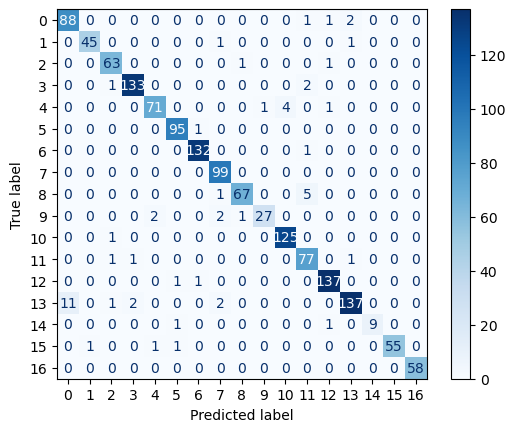

accuracy_score:  0.9613559322033899


In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from matplotlib import cm
from sklearn.metrics import accuracy_score


#0.0634 - accuracy: 0.9858 DAMN FIX ;_;
y_pred = best_cnn.predict(X_val)

conf_matrix = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=cm.Blues)
plt.show()

score = accuracy_score(y_val,y_pred)
print("accuracy_score: ", score)

In [4]:
import keras


best_model = keras.models.load_model('best_model.keras')


NameError: name 'X_test' is not defined